# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:24<00:00, 2.43KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

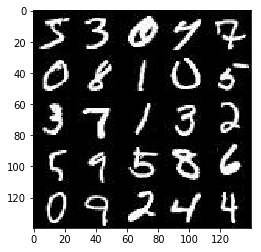

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

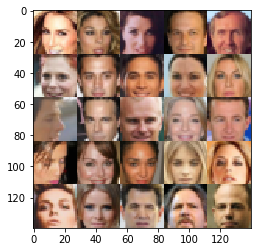

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/hackintoshrao/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.9442... Generator Loss: 1.1426


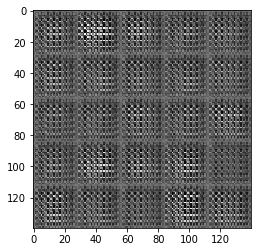

Epoch 1/2... Batch 20... Discriminator Loss: 3.5503... Generator Loss: 0.0710


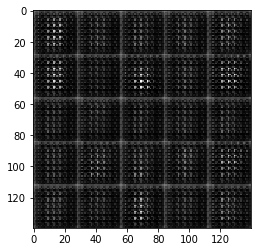

Epoch 1/2... Batch 30... Discriminator Loss: 0.7230... Generator Loss: 1.4455


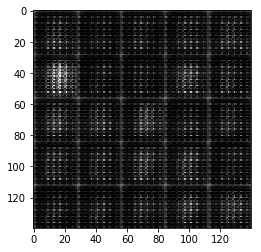

Epoch 1/2... Batch 40... Discriminator Loss: 1.6180... Generator Loss: 0.9680


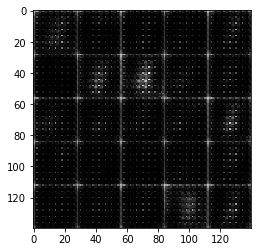

Epoch 1/2... Batch 50... Discriminator Loss: 0.7602... Generator Loss: 1.5710


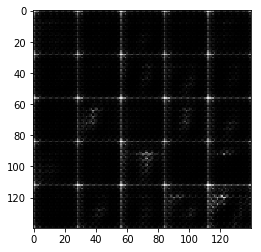

Epoch 1/2... Batch 60... Discriminator Loss: 0.8398... Generator Loss: 2.5601


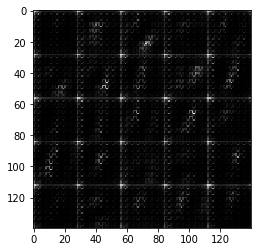

Epoch 1/2... Batch 70... Discriminator Loss: 1.1294... Generator Loss: 1.2683


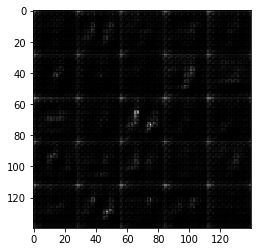

Epoch 1/2... Batch 80... Discriminator Loss: 0.8711... Generator Loss: 2.3863


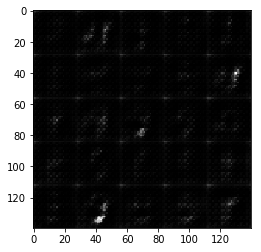

Epoch 1/2... Batch 90... Discriminator Loss: 1.0960... Generator Loss: 1.6432


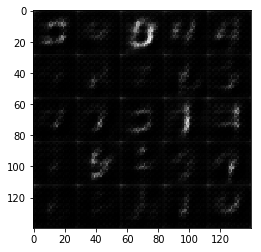

Epoch 1/2... Batch 100... Discriminator Loss: 1.2118... Generator Loss: 1.7009


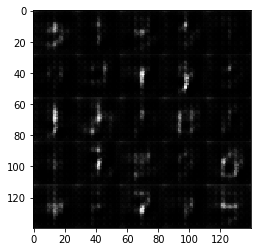

Epoch 1/2... Batch 110... Discriminator Loss: 1.3501... Generator Loss: 0.7134


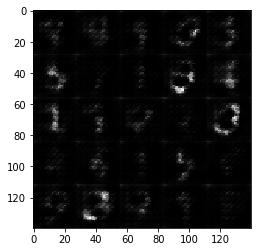

Epoch 1/2... Batch 120... Discriminator Loss: 1.2163... Generator Loss: 1.3831


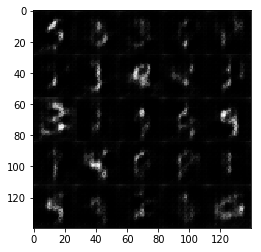

Epoch 1/2... Batch 130... Discriminator Loss: 1.3540... Generator Loss: 0.8062


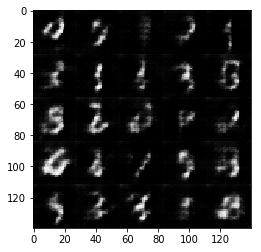

Epoch 1/2... Batch 140... Discriminator Loss: 1.4361... Generator Loss: 0.5400


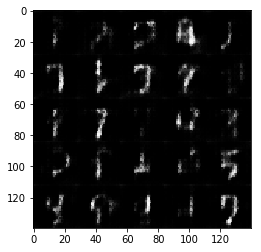

Epoch 1/2... Batch 150... Discriminator Loss: 1.5947... Generator Loss: 0.5083


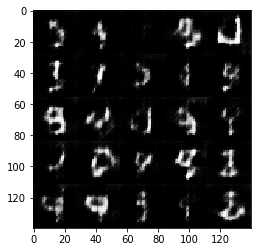

Epoch 1/2... Batch 160... Discriminator Loss: 1.2925... Generator Loss: 1.4286


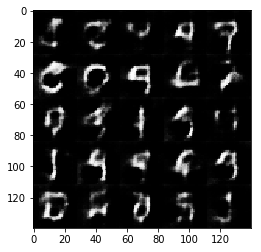

Epoch 1/2... Batch 170... Discriminator Loss: 1.5022... Generator Loss: 2.4782


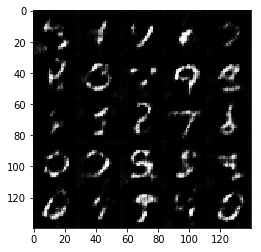

Epoch 1/2... Batch 180... Discriminator Loss: 1.2301... Generator Loss: 1.4060


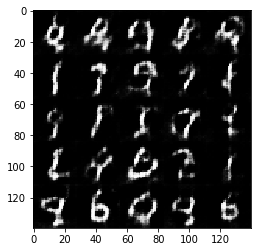

Epoch 1/2... Batch 190... Discriminator Loss: 1.1272... Generator Loss: 0.8068


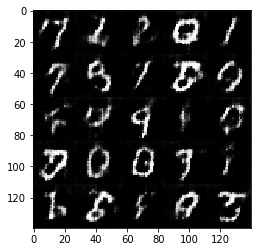

Epoch 1/2... Batch 200... Discriminator Loss: 1.2658... Generator Loss: 0.7386


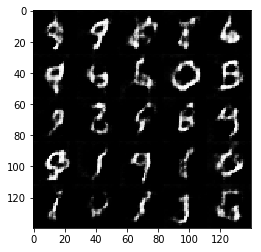

Epoch 1/2... Batch 210... Discriminator Loss: 1.1558... Generator Loss: 0.9888


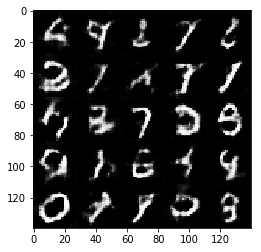

Epoch 1/2... Batch 220... Discriminator Loss: 1.1341... Generator Loss: 0.8623


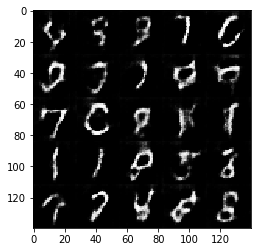

Epoch 1/2... Batch 230... Discriminator Loss: 1.2186... Generator Loss: 0.9207


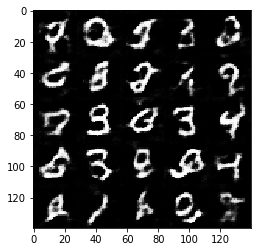

Epoch 1/2... Batch 240... Discriminator Loss: 1.2576... Generator Loss: 0.7660


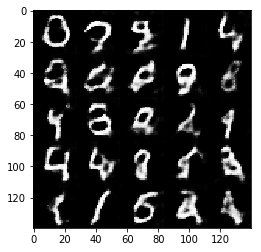

Epoch 1/2... Batch 250... Discriminator Loss: 1.2658... Generator Loss: 0.6597


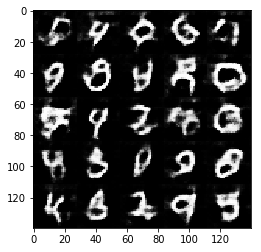

Epoch 1/2... Batch 260... Discriminator Loss: 1.4751... Generator Loss: 1.9710


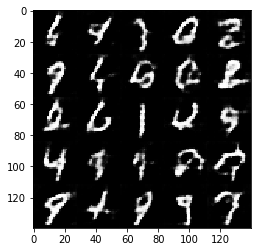

Epoch 1/2... Batch 270... Discriminator Loss: 1.1405... Generator Loss: 0.9808


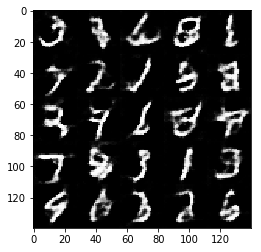

Epoch 1/2... Batch 280... Discriminator Loss: 1.1812... Generator Loss: 0.8463


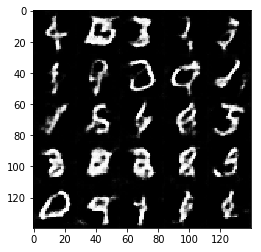

Epoch 1/2... Batch 290... Discriminator Loss: 1.4079... Generator Loss: 1.8824


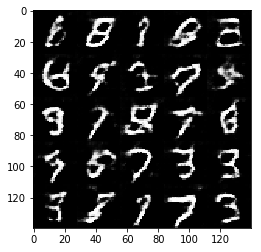

Epoch 1/2... Batch 300... Discriminator Loss: 1.3511... Generator Loss: 0.5492


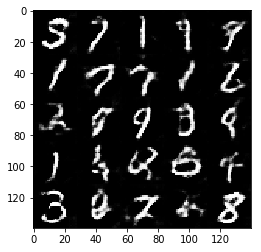

Epoch 1/2... Batch 310... Discriminator Loss: 1.1942... Generator Loss: 0.7590


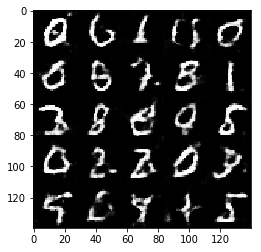

Epoch 1/2... Batch 320... Discriminator Loss: 1.1745... Generator Loss: 0.7386


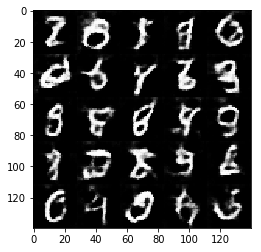

Epoch 1/2... Batch 330... Discriminator Loss: 1.1657... Generator Loss: 0.9353


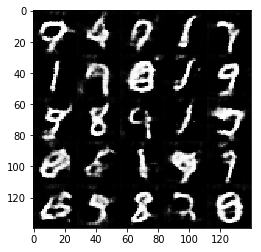

Epoch 1/2... Batch 340... Discriminator Loss: 1.2163... Generator Loss: 1.1467


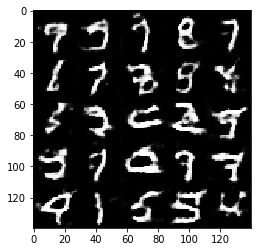

Epoch 1/2... Batch 350... Discriminator Loss: 2.4795... Generator Loss: 3.0427


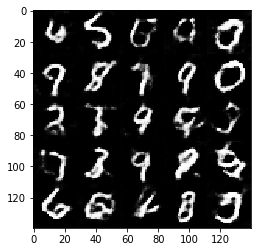

Epoch 1/2... Batch 360... Discriminator Loss: 1.2647... Generator Loss: 0.9278


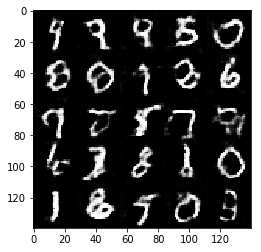

Epoch 1/2... Batch 370... Discriminator Loss: 1.1280... Generator Loss: 1.3752


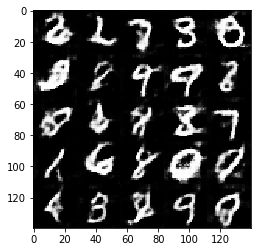

Epoch 1/2... Batch 380... Discriminator Loss: 1.1105... Generator Loss: 1.2907


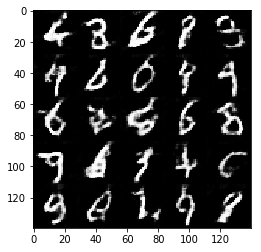

Epoch 1/2... Batch 390... Discriminator Loss: 1.3756... Generator Loss: 0.5467


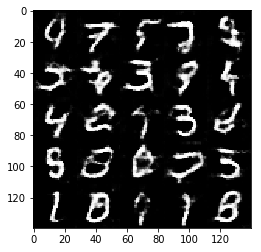

Epoch 1/2... Batch 400... Discriminator Loss: 1.0894... Generator Loss: 1.2991


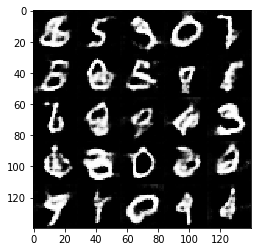

Epoch 1/2... Batch 410... Discriminator Loss: 1.0809... Generator Loss: 0.9737


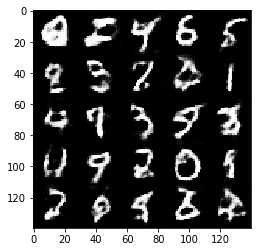

Epoch 1/2... Batch 420... Discriminator Loss: 0.9971... Generator Loss: 1.1530


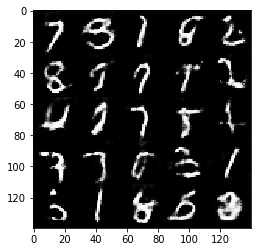

Epoch 1/2... Batch 430... Discriminator Loss: 1.0747... Generator Loss: 1.2683


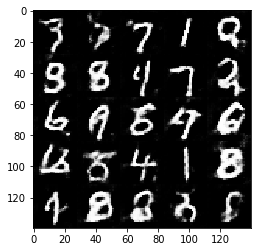

Epoch 1/2... Batch 440... Discriminator Loss: 1.2400... Generator Loss: 0.7605


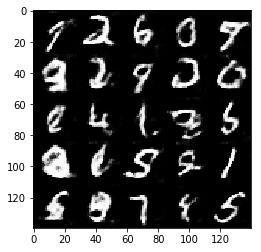

Epoch 1/2... Batch 450... Discriminator Loss: 1.1320... Generator Loss: 1.0913


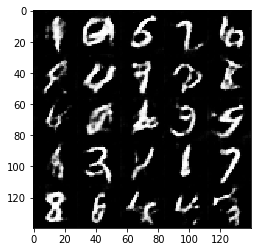

Epoch 1/2... Batch 460... Discriminator Loss: 1.1861... Generator Loss: 0.8634


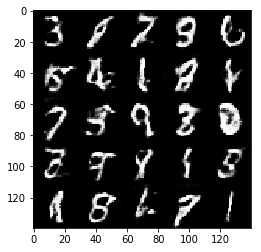

Epoch 2/2... Batch 10... Discriminator Loss: 1.3251... Generator Loss: 0.5975


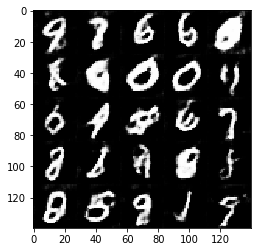

Epoch 2/2... Batch 20... Discriminator Loss: 1.0627... Generator Loss: 1.4146


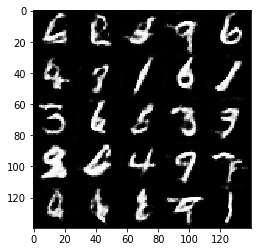

Epoch 2/2... Batch 30... Discriminator Loss: 2.0042... Generator Loss: 2.5834


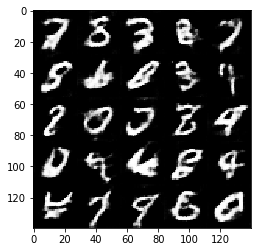

Epoch 2/2... Batch 40... Discriminator Loss: 1.2527... Generator Loss: 0.8381


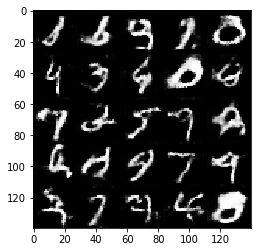

Epoch 2/2... Batch 50... Discriminator Loss: 1.2948... Generator Loss: 0.7861


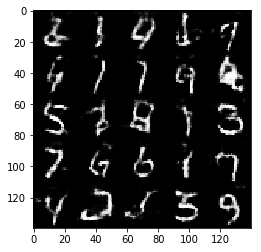

Epoch 2/2... Batch 60... Discriminator Loss: 1.1711... Generator Loss: 0.7993


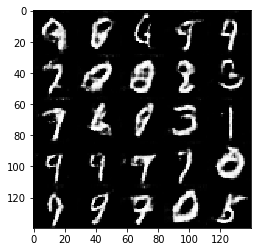

Epoch 2/2... Batch 70... Discriminator Loss: 1.3288... Generator Loss: 0.5995


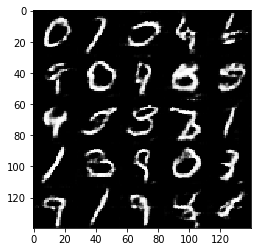

Epoch 2/2... Batch 80... Discriminator Loss: 1.1243... Generator Loss: 1.3385


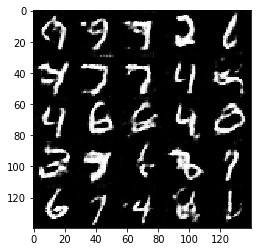

Epoch 2/2... Batch 90... Discriminator Loss: 1.2665... Generator Loss: 1.2203


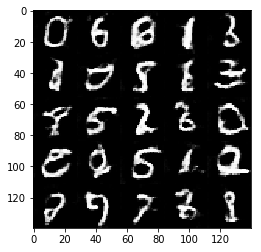

Epoch 2/2... Batch 100... Discriminator Loss: 1.2657... Generator Loss: 1.6889


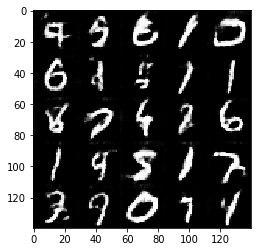

Epoch 2/2... Batch 110... Discriminator Loss: 1.6003... Generator Loss: 2.2303


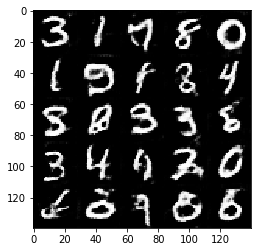

Epoch 2/2... Batch 120... Discriminator Loss: 1.1733... Generator Loss: 0.8414


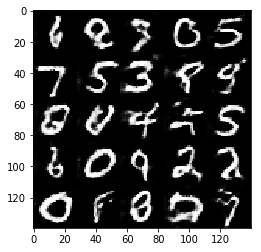

Epoch 2/2... Batch 130... Discriminator Loss: 1.5645... Generator Loss: 0.4249


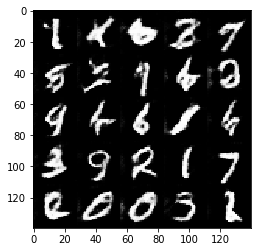

Epoch 2/2... Batch 140... Discriminator Loss: 1.1834... Generator Loss: 0.7759


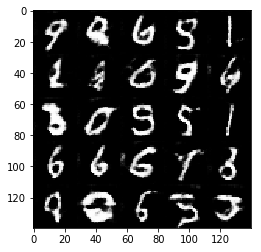

Epoch 2/2... Batch 150... Discriminator Loss: 1.1753... Generator Loss: 0.8788


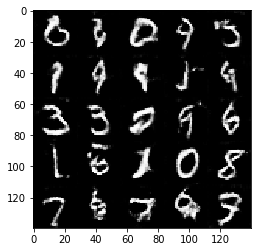

Epoch 2/2... Batch 160... Discriminator Loss: 1.1913... Generator Loss: 1.4010


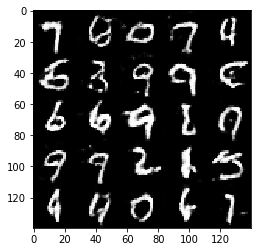

Epoch 2/2... Batch 170... Discriminator Loss: 1.3639... Generator Loss: 0.6469


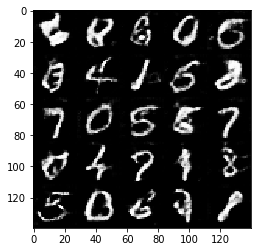

Epoch 2/2... Batch 180... Discriminator Loss: 1.1595... Generator Loss: 1.1944


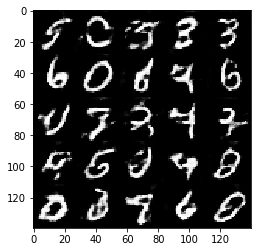

Epoch 2/2... Batch 190... Discriminator Loss: 1.4742... Generator Loss: 0.5289


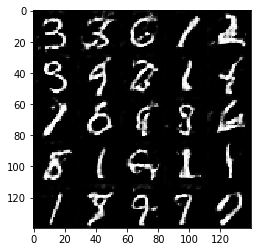

Epoch 2/2... Batch 200... Discriminator Loss: 1.1788... Generator Loss: 1.4383


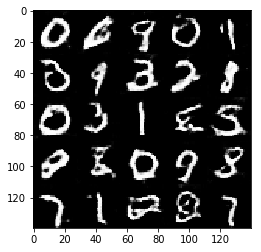

Epoch 2/2... Batch 210... Discriminator Loss: 1.4965... Generator Loss: 2.0205


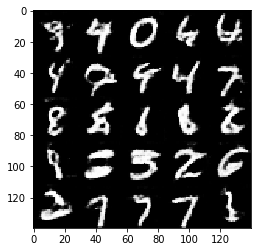

Epoch 2/2... Batch 220... Discriminator Loss: 1.1276... Generator Loss: 0.8684


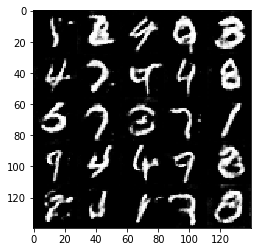

Epoch 2/2... Batch 230... Discriminator Loss: 1.6191... Generator Loss: 0.4131


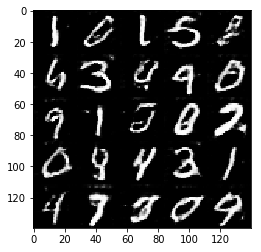

Epoch 2/2... Batch 240... Discriminator Loss: 1.2124... Generator Loss: 0.8349


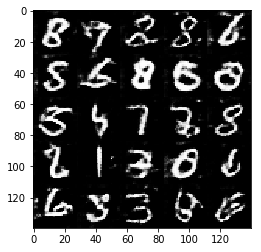

Epoch 2/2... Batch 250... Discriminator Loss: 1.1190... Generator Loss: 1.3690


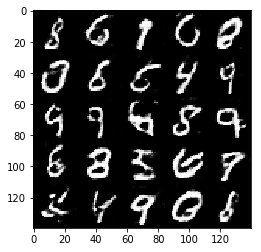

Epoch 2/2... Batch 260... Discriminator Loss: 1.2463... Generator Loss: 1.6537


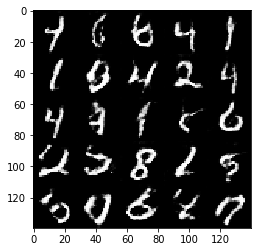

Epoch 2/2... Batch 270... Discriminator Loss: 1.1673... Generator Loss: 0.9325


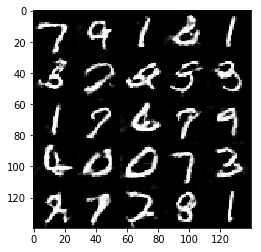

Epoch 2/2... Batch 280... Discriminator Loss: 1.1752... Generator Loss: 1.0672


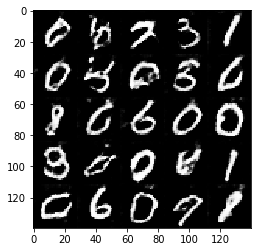

Epoch 2/2... Batch 290... Discriminator Loss: 1.2056... Generator Loss: 0.8392


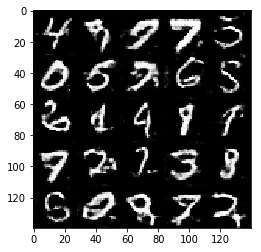

Epoch 2/2... Batch 300... Discriminator Loss: 1.5848... Generator Loss: 0.4023


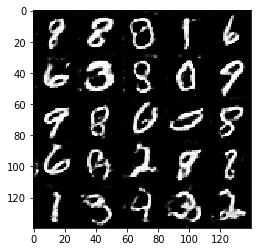

Epoch 2/2... Batch 310... Discriminator Loss: 1.2432... Generator Loss: 0.6692


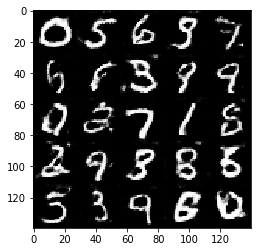

Epoch 2/2... Batch 320... Discriminator Loss: 1.5368... Generator Loss: 0.4375


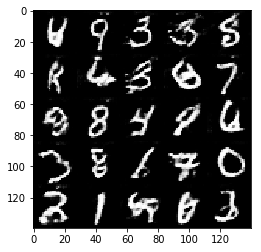

Epoch 2/2... Batch 330... Discriminator Loss: 1.0533... Generator Loss: 1.0902


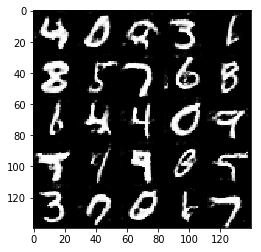

Epoch 2/2... Batch 340... Discriminator Loss: 1.3495... Generator Loss: 0.6558


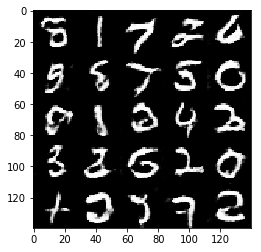

Epoch 2/2... Batch 350... Discriminator Loss: 1.5265... Generator Loss: 2.1749


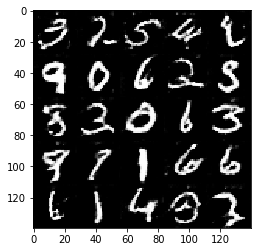

Epoch 2/2... Batch 360... Discriminator Loss: 1.2392... Generator Loss: 0.7021


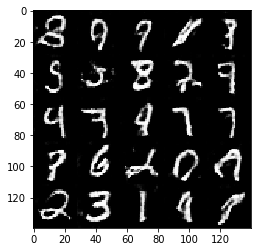

Epoch 2/2... Batch 370... Discriminator Loss: 1.3799... Generator Loss: 1.9442


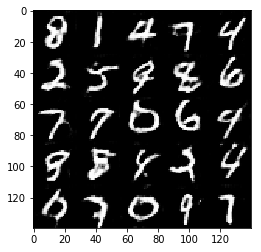

Epoch 2/2... Batch 380... Discriminator Loss: 1.0815... Generator Loss: 0.9482


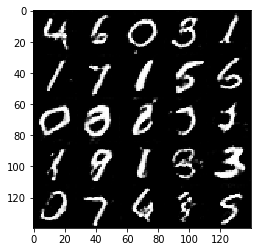

Epoch 2/2... Batch 390... Discriminator Loss: 1.2998... Generator Loss: 0.6829


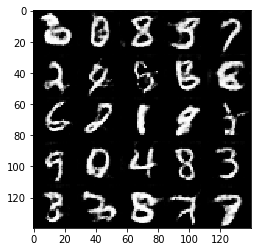

Epoch 2/2... Batch 400... Discriminator Loss: 1.1130... Generator Loss: 1.0959


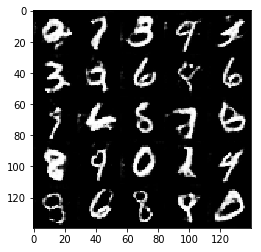

Epoch 2/2... Batch 410... Discriminator Loss: 1.1266... Generator Loss: 1.4416


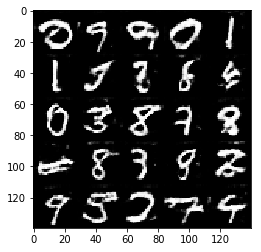

Epoch 2/2... Batch 420... Discriminator Loss: 0.9258... Generator Loss: 1.5573


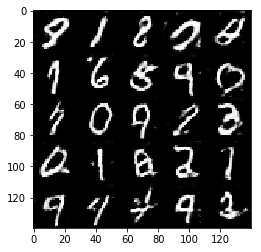

Epoch 2/2... Batch 430... Discriminator Loss: 1.2354... Generator Loss: 1.4320


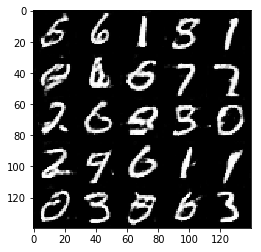

Epoch 2/2... Batch 440... Discriminator Loss: 1.1381... Generator Loss: 0.7776


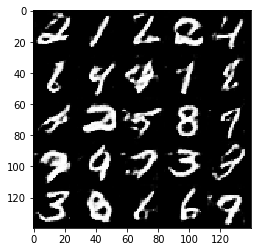

Epoch 2/2... Batch 450... Discriminator Loss: 1.1607... Generator Loss: 1.5595


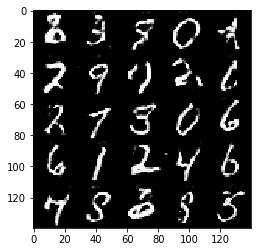

Epoch 2/2... Batch 460... Discriminator Loss: 1.2000... Generator Loss: 0.8081


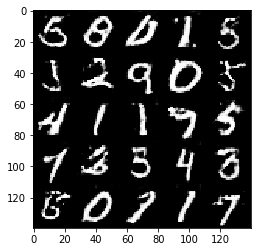

In [18]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.